In [1]:
import matplotlib.pyplot as plt
import numpy as np
from HelperFunctions import *

Read successful.


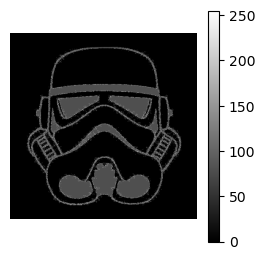

In [2]:
# Load image as numpy array
from PIL import Image

imageOG = None
with Image.open("StormTrooperHelmet.png") as im:
    imageOG = np.asarray(im)
    print("Read successful.")
if imageOG is None:
    print("Read failed.")
if np.size(imageOG,0) != np.size(imageOG,1):
    print("IMAGE INAPPROPRIATE SIZE.")

PreviewImage(imageOG, cmap='gray')

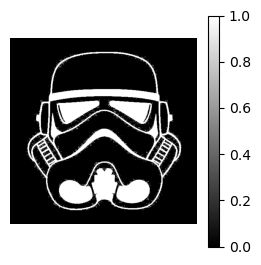

In [3]:
## Preprocess image to binary
image = imageOG.copy()

thresh = 10
image[np.where(imageOG<=thresh)] = 0
image[np.where(imageOG>thresh)] = 1

PreviewImage(image, cmap='gray')

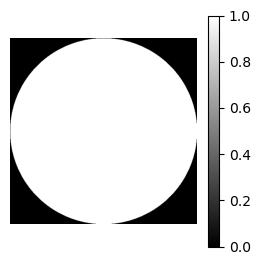

In [4]:
## Create mask as inscribed circle
numRows = np.size(image, 0)
numCols = np.size(image, 1)

circleRad = numRows/2
circleCenter = numRows/2

mask = np.zeros(image.shape, dtype=bool)

for row in range(numRows):
    for col in range(numCols):
        if np.sqrt(np.power(row-circleCenter,2) + np.power(col-circleCenter,2)) <= circleRad:
            mask[row, col] = 1

PreviewImage(mask, cmap='gray')

(302500,)


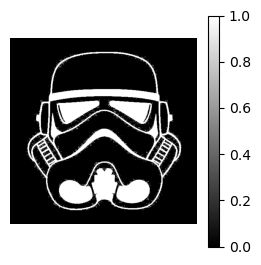

In [5]:
## Apply mask to image

image = np.asarray(image, dtype=np.int16)
image[np.where(mask<0.5)] = 0

imageflat = np.reshape(image, (-1))
print(imageflat.shape)

PreviewImage(image, cmap='gray')

In [6]:
## Create N points around unit circle
N = 40

indices = np.arange(N)
pointGap = 2*np.pi/N
points = np.vstack((np.cos(indices*pointGap), np.sin(indices*pointGap))).T
print("Points.shape:", points.shape)

Points.shape: (40, 2)


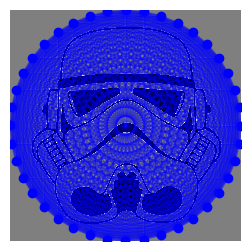

In [7]:
## Plot points and lines

# Get plot
disp = PreviewImage(image, plot=False, plotCB=False)
plt.figure(disp.number)

# Plot points
plt.scatter(points[:,0], points[:,1], c='blue', linewidths=1)

# Plot lines
for i in range(N-1):
    for j in range(i+1,N):
        plt.plot([points[i,0],points[j,0]], [points[i,1],points[j,1]], c='blue', alpha=0.3, linewidth=1)
plt.show()

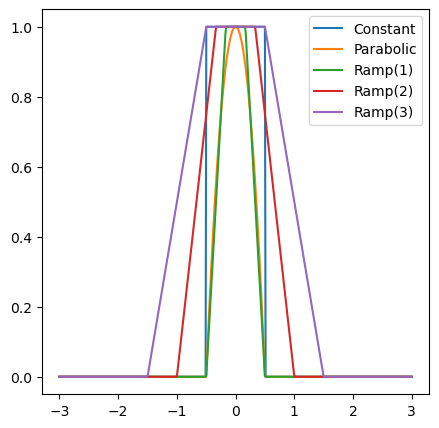

In [8]:
## Make distance weights, range scale [0,1]

def DW_constant(distance, width=1):
    dist = np.asarray(distance)
    weights = np.zeros(dist.shape)
    IM = np.where(np.abs(dist)<=width/2) # index mask
    weights[IM] = 1
    return weights

def DW_parabolic(distance):
    dist = np.asarray(distance)
    weights = np.zeros(dist.shape)
    IM = np.abs(dist)<=0.5 # index mask
    weights[IM] = 1 - 4 * np.power(dist[IM],2)
    return weights

def DW_ramp(distance, width=1):
    dist = np.asarray(distance)
    weights = np.zeros(dist.shape)
    weights[np.where(np.abs(dist)<=width/6)] = 1
    IM = np.where(np.logical_and(width/6<np.abs(dist),np.abs(dist)<=width/2))
    weights[IM] = -3/width * np.abs(dist[IM]) + 3/2
    return weights    


distances = np.linspace(-3, 3, 500)
plt.figure(figsize=(5,5))
plt.plot(distances, DW_constant(distances), label='Constant')
plt.plot(distances, DW_parabolic(distances), label='Parabolic')
plt.plot(distances, DW_ramp(distances, width=1), label='Ramp(1)')
plt.plot(distances, DW_ramp(distances, width=2), label='Ramp(2)')
plt.plot(distances, DW_ramp(distances, width=3), label='Ramp(3)')
plt.legend()
plt.show()

In [9]:
# Generate position grid
size = np.size(image, 0)

gridX = np.linspace(-1, 1, size)
gridX = np.atleast_2d(gridX)
gridX = np.repeat(gridX, size, axis=0)

gridY = np.linspace(1, -1, size)
gridY = np.atleast_2d(gridY).T
gridY = np.repeat(gridY, size, axis=1)

gridXY = np.dstack((gridX, gridY))

In [10]:
## Flatten everything

imageShape = image.shape
imageShapeFlat = [image.size]

gridXflat = np.reshape(gridX, [-1,1])
gridYflat = np.reshape(gridY, [-1,1])
gridXYflat = np.reshape(gridXY, [-1,2])
maskflat = np.reshape(mask, [-1,1])

maskInd = np.where(maskflat>0.5)[0]

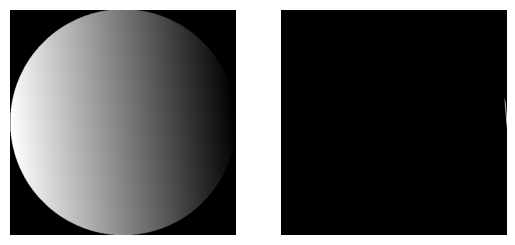

Generated (780) line weights.
Generated (780) line index masks.


In [11]:
# Generate lines
lineWeights = []
lineIndexMasks = []

plotted = False
for i in range(0, N-1):
    for j in range(i+1, N):
        pointA = points[i]
        pointB = points[j]

        diffAB = pointB-pointA
        dir = np.cross(np.hstack((diffAB, 0)), np.array([0, 0, 1])) # 3D dot product, get perpendicular vector
        dir = dir[0:2] / np.linalg.norm(dir[0:2]) # Back to 2D, normalize

        distFromLine = np.abs(np.dot(gridXYflat[maskInd, :], dir) - np.dot(pointA, dir))
        # print(gridXYflat.shape)
        # print(distFromLine.shape)
        lineWeight = DW_ramp(distFromLine, width=0.01)
        lineIndexMask = np.nonzero(lineWeight)[0]

        lineWeights.append(lineWeight)
        lineIndexMasks.append(lineIndexMask)

        plotA = np.zeros(imageShapeFlat)
        plotA[maskInd] = distFromLine
        plotA = np.reshape(plotA, imageShape)
        plotB = np.zeros(imageShapeFlat)
        plotB[maskInd] = lineWeight
        plotB = np.reshape(plotB, imageShape)

        if not plotted:
            plotted = True

            plt.subplot(1,2,1)
            plt.imshow(plotA, cmap='gray', extent=[-1,1,-1,1])
            plt.axis('off')

            plt.subplot(1,2,2)
            plt.imshow(plotB, cmap='gray', extent=[-1,1,-1,1])
            plt.axis('off')
            plt.show()

print("Generated (", len(lineWeights), ") line weights.", sep='')
print("Generated (", len(lineIndexMasks), ") line index masks.", sep='')
numLines = len(lineWeights)

In [12]:
lineStrength = 0.05

def plotLines(lineNumbers, minThresh = -np.inf, maxThresh = np.inf):
    boardFlat = np.zeros(imageShapeFlat)
    boardFlat[0] = 1 # Set range

    # Iterate through each line and plot
    for lineIndex in range(numLines):
        lineWeight = lineWeights[lineIndex]
        lineNumber = lineNumbers[lineIndex]

        boardFlat[maskInd] += lineStrength*lineNumber*lineWeight

    # Enforce bounds
    boardFlat[boardFlat < minThresh] = minThresh
    boardFlat[boardFlat > maxThresh] = maxThresh

    # Plot
    board = np.reshape(boardFlat, imageShape)
    plt.imshow(board, cmap='gray', extent=[-1,1,-1,1], interpolation='none')
    plt.axis('off')
    plt.colorbar()
    # plt.show()

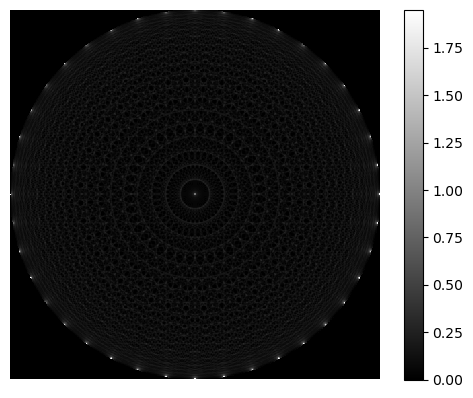

In [13]:
plotLines(np.ones(numLines))

In [14]:
# Create optimization problem, using pseudo-inverse

A = np.vstack(lineWeights).T * lineStrength
print("A.shape:", A.shape)
pinvA = np.linalg.pinv(A)
print("pinvA.shape:", pinvA.shape)

A.shape: (237523, 780)
pinvA.shape: (780, 237523)


In [15]:
b = imageflat[maskInd]
b = np.atleast_2d(b).T
print("b.shape:", b.shape)

pInv_lineNumbers = np.dot(pinvA,b)
print("lineNumbers.shape:", pInv_lineNumbers.shape)
print("Min:", np.min(pInv_lineNumbers))
print("Max:", np.max(pInv_lineNumbers))

b.shape: (237523, 1)
lineNumbers.shape: (780, 1)
Min: -3.4646597797471377
Max: 8.862051473887899


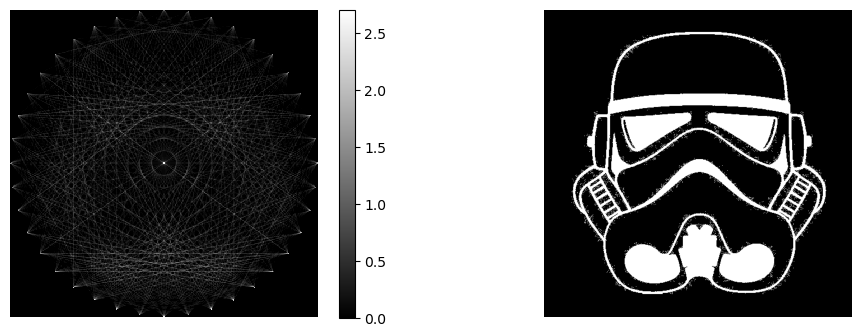

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plotLines(pInv_lineNumbers, 0, 5)
plt.subplot(1,2,2)
plt.imshow(image, cmap='gray', extent=[-1,1,-1,1])
plt.axis('off')
plt.show()

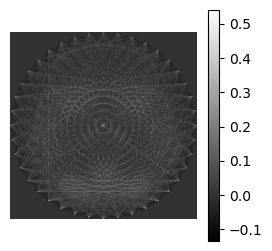

Epoch 0:
	0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 

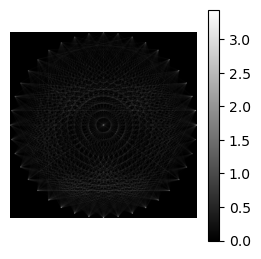

Epoch 1:
	0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 

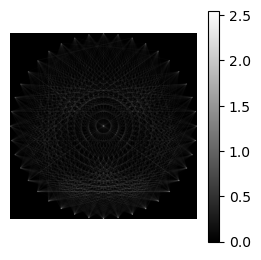

Epoch 2:
	0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 

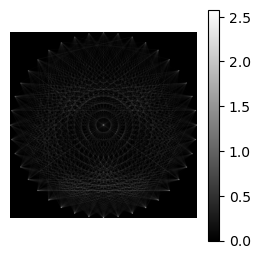

Epoch 3:
	0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 

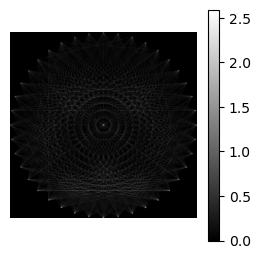

Epoch 4:
	0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 

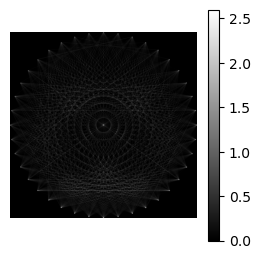

In [17]:
## Greedy Algorithm
# Start with pInv then tighten restrictions for each string

lineStrength = 0.01

# Initialize line numbers from pInv results
greedy_lineNumbers = pInv_lineNumbers

# Preview current estimate
boardflat = np.zeros(imageShapeFlat)
for lineIndex in range(numLines):
    lineWeight = lineWeights[lineIndex]
    lineIndexMask = lineIndexMasks[lineIndex]
    lineNumber = greedy_lineNumbers[lineIndex]

    indexMask = maskInd[lineIndexMask]
    boardflat[indexMask] += lineStrength * lineNumber * lineWeight[lineIndexMask]
board = np.reshape(boardflat, imageShape)
PreviewImage(board, cmap='gray')

numEpochs = 5
for epoch in range(numEpochs):
    print("Epoch ", epoch, ":", sep='')
    print("\t", end='', flush=True)

    # Iterate for each line
    for chosenLineIndex in range(numLines):
        if chosenLineIndex % 50 == 0:
            print(chosenLineIndex, ", ", sep='', end='', flush=True)
        # print("Line ", chosenLineIndex, ":", sep='')
            
        # Build estimate excluding this string
        boardflat = np.zeros(imageShapeFlat)
        for lineIndex in range(numLines):
            if lineIndex == chosenLineIndex:
                continue
            lineWeight = lineWeights[lineIndex]
            lineIndexMask = lineIndexMasks[lineIndex]
            lineNumber = greedy_lineNumbers[lineIndex]

            indexMask = maskInd[lineIndexMask]
            boardflat[indexMask] += lineStrength * lineNumber * lineWeight[lineIndexMask]
        # Find estimation error within mask
        boardError = imageflat[maskInd] - boardflat[maskInd]
        # Mask out desired indices
        chosenLineWeight = lineWeights[chosenLineIndex]
        chosenLineIndexMask = lineIndexMasks[chosenLineIndex]
        
        valueMean = np.mean(boardError[chosenLineIndexMask] * chosenLineWeight[chosenLineIndexMask]) / lineStrength
        chosenLineNumber = np.clip(np.round(valueMean), 0, np.inf)
        # print("\tchosenLineNumber = ", np.round(valueMean,4), " -> ", chosenLineNumber, sep='')
        greedy_lineNumbers[chosenLineIndex] = chosenLineNumber
    
    # Preview current estimate
    boardflat = np.zeros(imageShapeFlat)
    for lineIndex in range(numLines):
        lineWeight = lineWeights[lineIndex]
        lineIndexMask = lineIndexMasks[lineIndex]
        lineNumber = greedy_lineNumbers[lineIndex]

        indexMask = maskInd[lineIndexMask]
        boardflat[indexMask] += lineStrength * lineNumber * lineWeight[lineIndexMask]
    board = np.reshape(boardflat, imageShape)
    PreviewImage(board, cmap='gray')